In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline

In [18]:
# global constants
BATCH_SIZE = 32
BETA = 3
RHO = 0.01
N_INP = 784
N_HIDDEN = 300
N_EPOCHS = 50
use_sparse = True

In [4]:
class SparseAutoencoder(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(n_inp, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_inp)

    def forward(self, x):
        encoded = F.sigmoid(self.encoder(x))
        decoded = F.sigmoid(self.decoder(encoded))
        return encoded, decoded

In [5]:
rho = torch.FloatTensor([RHO for _ in range(N_HIDDEN)]).unsqueeze(0)

In [22]:
trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='data/', train=True, transform=trans, download=True)
test_set = datasets.MNIST(root='data/', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True)

test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=BATCH_SIZE,
        shuffle=False)

In [12]:
auto_encoder = SparseAutoencoder(N_INP, N_HIDDEN)
optimizer = optim.Adam(auto_encoder.parameters(), lr=1e-3)

In [25]:
criterion =  nn.MSELoss()

In [13]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = F.softmax(p)
    q = F.softmax(q)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))
    return s1 + s2

In [14]:
N_COLS = 8
N_ROWS = 4
view_data = [test_set[i][0] for i in range(N_ROWS * N_COLS)]
plt.figure(figsize=(20, 4))

<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

In [26]:
for epoch in range(N_EPOCHS):
    for b_index, (x, _) in enumerate(train_loader):
        x = x.view(x.size()[0], -1)
        x = torch.autograd.Variable(x)
        encoded, decoded = auto_encoder(x)
        loss = criterion(decoded,x)
        if use_sparse:
            rho_hat = torch.sum(encoded, dim=0, keepdim=True)
            sparsity_penalty = BETA * kl_divergence(rho, rho_hat)
            loss = loss + sparsity_penalty
        else:
            loss = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: [%3d], Loss: %.4f" %(epoch + 1, loss.data))

C:\Users\mohit_tare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
C:\Users\mohit_tare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch: [  1], Loss: 0.0961
Epoch: [  2], Loss: 0.0676
Epoch: [  3], Loss: 0.0564
Epoch: [  4], Loss: 0.0492
Epoch: [  5], Loss: 0.0509
Epoch: [  6], Loss: 0.0529
Epoch: [  7], Loss: 0.0556
Epoch: [  8], Loss: 0.0475
Epoch: [  9], Loss: 0.0371
Epoch: [ 10], Loss: 0.0426
Epoch: [ 11], Loss: 0.0409
Epoch: [ 12], Loss: 0.0328
Epoch: [ 13], Loss: 0.0291
Epoch: [ 14], Loss: 0.0332
Epoch: [ 15], Loss: 0.0289
Epoch: [ 16], Loss: 0.0280
Epoch: [ 17], Loss: 0.0253
Epoch: [ 18], Loss: 0.0311
Epoch: [ 19], Loss: 0.0286
Epoch: [ 20], Loss: 0.0249
Epoch: [ 21], Loss: 0.0228
Epoch: [ 22], Loss: 0.0237
Epoch: [ 23], Loss: 0.0186
Epoch: [ 24], Loss: 0.0219
Epoch: [ 25], Loss: 0.0194
Epoch: [ 26], Loss: 0.0202
Epoch: [ 27], Loss: 0.0160
Epoch: [ 28], Loss: 0.0152
Epoch: [ 29], Loss: 0.0167
Epoch: [ 30], Loss: 0.0156
Epoch: [ 31], Loss: 0.0183
Epoch: [ 32], Loss: 0.0179
Epoch: [ 33], Loss: 0.0159
Epoch: [ 34], Loss: 0.0149
Epoch: [ 35], Loss: 0.0170
Epoch: [ 36], Loss: 0.0138
Epoch: [ 37], Loss: 0.0132
E

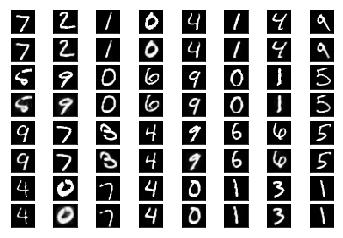

In [27]:
for i in range(N_ROWS * N_COLS):
    # original image
    r = i // N_COLS
    c = i % N_COLS + 1
    ax = plt.subplot(2 * N_ROWS, N_COLS, 2 * r * N_COLS + c)
    plt.imshow(view_data[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed image
    ax = plt.subplot(2 * N_ROWS, N_COLS, 2 * r * N_COLS + c + N_COLS)
    x = torch.autograd.Variable(view_data[i])
    e, y = auto_encoder(x.view(1, -1))
    plt.imshow(y.detach().squeeze().numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()